In [1]:
import glob
import numpy as np
import pyklip.instruments.GPI as GPI

# read in the data into a dataset
filelist = glob.glob("betaPic/*.fits") #fits files in /betaPic directory
dataset = GPI.GPIData(filelist)

# generate instrumental PSF
boxsize = 17 # we want a 17x17 pixel box centered on the instrumental PSF
dataset.generate_psfs(boxrad=boxsize//2) # this function extracts the satellite spots from the data
# now dataset.psfs contains a 37x25x25 spectral cube with the instrumental PSF
# normalize the instrumental PSF so the peak flux is unity
dataset.psfs /= (np.mean(dataset.spot_flux.reshape([dataset.spot_flux.shape[0] // 37, 37]),
                         axis=0)[:, None, None])

Reading File: betaPic/S20131210S0104_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0097_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0092_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0098_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0099_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0096_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0105_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0093_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0100_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0111_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0103_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0095_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0106_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0109_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0110_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0108_spdc_distorcorr.fits
Reading File: betaPic/S20131210S0102_spdc_distorcorr.fits
Reading File: 

In [3]:
# setup FM guesses
# You should change these to be suited to your data!
numbasis = np.array([7]) # KL basis cutoffs you want to try
guesssep = 30.1 # estimate of separation in pixels
guesspa = 212.2 # estimate of position angle, in degrees
guessflux = 5e-5 # estimated contrast
dn_per_contrast = dataset.dn_per_contrast

# initialize the FM Planet PSF class
import pyklip.fmlib.fmpsf as fmpsf
fm_class = fmpsf.FMPlanetPSF(dataset.input.shape, numbasis, guesssep, guesspa, guessflux, dataset.psfs,
                             np.unique(dataset.wvs),dn_per_contrast, star_spt='A6',)

In [4]:
# PSF subtraction parameters
# You should change these to be suited to your data!
outputdir = "." # where to write the output files
prefix = "betpic-131210-j-fmpsf" # fileprefix for the output files
annulus_bounds = [[guesssep-15, guesssep+15]] # one annulus centered on the planet
subsections = 1 # we are not breaking up the annulus
padding = 0 # we are not padding our zones
movement = 4 # we are using an conservative exclusion criteria of 4 pixels

# run KLIP-FM
import pyklip.fm as fm
fm.klip_dataset(dataset, fm_class, fileprefix=prefix, numbasis=numbasis, annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement)
import os
import astropy.io.fits as fits
# read in outputs
output_prefix = os.path.join(outputdir, prefix)
fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")

# get FM frame, use KL=7
fm_frame = fm_hdu[1].data[0]
fm_centx = fm_hdu[1].header['PSFCENTX']
fm_centy = fm_hdu[1].header['PSFCENTY']

# get data_stamp frame, use KL=7
data_frame = data_hdu[1].data[0]
data_centx = data_hdu[1].header["PSFCENTX"]
data_centy = data_hdu[1].header["PSFCENTY"]

# get initial guesses
guesssep = fm_hdu[0].header['FM_SEP']
guesspa = fm_hdu[0].header['FM_PA']

Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 5673.6260323831675 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool


/Users/jacobgolomb/Documents/KLIP/pyklip/pyklip/fm.py:1341: RuntimeWarning: divide by zero encountered in true_divide
  sub_imgs = sub_imgs / sub_imgs_numstacked[:,:,:,None]


Writing KLIPed Images to directory /Users/jacobgolomb/Documents/KLIP


/Users/jacobgolomb/Documents/KLIP/pyklip/pyklip/fm.py:1835: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * klipped, axis=(1,2))
/Users/jacobgolomb/Documents/KLIP/pyklip/pyklip/fm.py:1855: RuntimeWarning: Mean of empty slice
  KLmode_spectral_cubes = np.nanmean(pixel_weights * klipped, axis=1)


In [5]:
import pyklip.fitpsf as fitpsf

# create FMAstrometry/Fit object that does Multinest sampling, set fm_basename and null_basename to the prefixes you want each sampler to save in output_dir
output_dir = 'chains/' #will save sampling files in this directory
fit = fitpsf.PlanetEvidence(guesssep, guesspa, 13, sampling_outputdir=output_dir, l_only = False, fm_basename='Planet', null_basename='Null')

# generate FM stamp
# padding should be greater than 0 so we don't run into interpolation problems
fit.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

# generate data_stamp stamp
# not that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
# exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
fit.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)
# set kernel, no read noise
corr_len_guess = 3.
corr_len_label = r"$l$"
fit.set_kernel("matern32", [corr_len_guess], [corr_len_label])
# set bounds
x_range = 1.5 # pixels
y_range = 1.5 # pixels
flux_range = 1. # flux can vary by an order of magnitude
corr_len_range = 1. # between 0.3 and 30
fit.set_bounds(x_range, y_range, flux_range, [corr_len_range])

In [6]:
#Run the pymultinest fit
fit.multifit()

  analysing data from chains/Planet-.txt
  analysing data from chains/Null-.txt


(<Figure size 698.4x698.4 with 16 Axes>, <Figure size 547.2x547.2 with 9 Axes>)

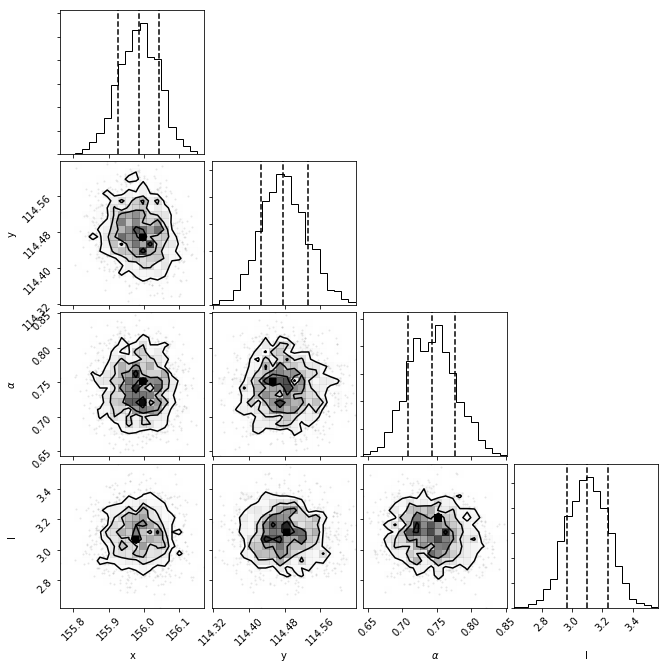

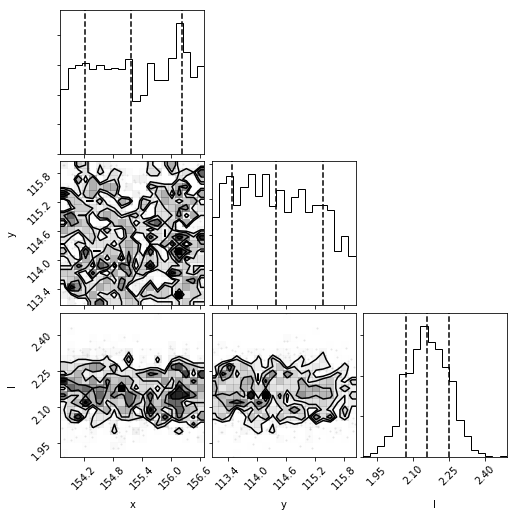

In [7]:
#Output corner plots from these fits (first figure is the H1 hypothesis, followed up H0)
fit.fit_plots()

In [8]:
#Store the Multinest statistics in a tuple called "evidence". evidence[0] will be a dict
#with the statsitics for the H1 hypothesis. evidence[1] is the same, for the null hypothesis
evidence = fit.fit_stats()

  analysing data from chains/Planet-.txt
  analysing data from chains/Null-.txt


In [9]:
#Forward model evidence
fm_evidence = evidence[0]['nested sampling global log-evidence']
#forward model parameter distributions, containing the median and percentiles for each
fm_posteriors = evidence[0]['marginals']

#Null model evidence
null_evidence = evidence[1]['nested sampling global log-evidence']
#null parameter distributions, containing the median and percentiles for each
null_posteriors = evidence[1]['marginals']

In [11]:
#Compute evidence ratio for forward model relative to null hypothesis model
evidence_ratio = np.exp(fm_evidence)/np.exp(null_evidence)
print(evidence_ratio)

1.372006676076942e+77


In [1]:
#Print the SNR and the residual plot
fit.fm_residuals()

NameError: name 'fit' is not defined